# Анализ воронки интернет-продаж

**Целью** работы является характеристика воронки событий. При этом необходимо выяснить, на каком шаге теряется больше всего пользователей и сколько пользователей доходят до события оплаты. Проверить гипотезу о том, что изменение шрифта повлияет на поведение пользователей.

# Вывод

- в среднем пользователи совершают 20 событий на сайте
- около 48% пользователей доходят до страницы успешной оплаты
- при этом, 40% пользователей не переходят с главной страницы до страницы продукта
- от страницы продукта до корзины теряется ещё 20%
- практически все пользователи (95%), положившие товар в корзину, совершают покупку
- изменение шрифта никак не повлияло на пользователей, при этом нужно отметить то, что данные собраны качественно

Улучшение продаж возможно в случае увеличения перехода пользователей на сайт, поскольку воронка работает хорошо.

# Подготовка данных

## Загрузка данных

In [1]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
from scipy import stats as st
import math as mth

In [2]:
data = pd.read_csv('logs_exp.csv', sep='\t')

In [3]:
data.columns=['event_name', 'device_id', 'event_timestampt', 'exp_id']

Все столбцы приводятся к "змеиному" регистру

In [4]:
pd.options.mode.chained_assignment = None #используется чтобы избавиться от ошибки SettingWithCopyWarning
data['event_time'] = pd.to_datetime(data['event_timestampt'], unit='s')
data['event_date'] = data['event_time'].dt.floor('D')

Создаются два новых столбца с датой, а также датой и временем совершения события

In [48]:
data.head(5)

,event_name,device_id,event_timestampt,exp_id,event_time,event_date
2829,MainScreenAppear,3737462046622621720,1564618080,246,2019-08-01 00:08:00,2019-08-01
2830,MainScreenAppear,3737462046622621720,1564618135,246,2019-08-01 00:08:55,2019-08-01
2831,OffersScreenAppear,3737462046622621720,1564618138,246,2019-08-01 00:08:58,2019-08-01
2832,MainScreenAppear,1433840883824088890,1564618139,247,2019-08-01 00:08:59,2019-08-01
2833,MainScreenAppear,4899590676214355127,1564618215,247,2019-08-01 00:10:15,2019-08-01


В таблице 244126 строк и 6 столбцов

## Проверка на пропуски и дубликаты

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   event_name        244126 non-null  object        
 1   device_id         244126 non-null  int64         
 2   event_timestampt  244126 non-null  int64         
 3   exp_id            244126 non-null  int64         
 4   event_time        244126 non-null  datetime64[ns]
 5   event_date        244126 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(3), object(1)
memory usage: 11.2+ MB


Среди данных отсутвуют пропуски

In [7]:
print('Дубликаты:', data.duplicated().sum())

Дубликаты: 413


Найдено 413 строк-дубликатов

In [8]:
duplicateRows = data[data.duplicated()]

In [47]:
round(len(duplicateRows) / len(data) * 100, 2)

0.17

Действительно существуют полные дубликаты, количество которых не превышает 0,17%

In [10]:
data = data.drop_duplicates()

In [11]:
print('Дубликаты:', data.duplicated().sum())

Дубликаты: 0


После удаления повторяющихся строк, дубликатов не остается

## Изучение данных

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243713 entries, 0 to 244125
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   event_name        243713 non-null  object        
 1   device_id         243713 non-null  int64         
 2   event_timestampt  243713 non-null  int64         
 3   exp_id            243713 non-null  int64         
 4   event_time        243713 non-null  datetime64[ns]
 5   event_date        243713 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(3), object(1)
memory usage: 13.0+ MB


Всего после удаления дубликатов (их доля была менее 0,17%) в логах 243'713 событий.

In [13]:
data['event_name'].unique()

array(['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear', 'Tutorial'], dtype=object)

Всего изначально 5 видов события:
- MainScreenAppear - просмотр главного экрана
- PaymentScreenSuccessful - экран успешной оплаты
- CartScreenAppear - экран корзины
- OffersScreenAppear - экран с предложением
- Tutorial - экран туториала

In [14]:
data['device_id'].nunique()

7551

Всего 7551 уникальных пользователей

In [15]:
round(data.pivot_table(index='device_id', values=['event_name'], aggfunc={'count'}).mean(), 2)

event_name  count    32.28
dtype: float64

Среднее количество событий на пользователя без учёта выбросов - 32,28

In [16]:
round(data.pivot_table(index='device_id', values=['event_name'], aggfunc={'count'}).median(), 2)

event_name  count    20.0
dtype: float64

Медианное значение, не учитывающее большие отклонения от нормы, составляет 20 событий. Это значение справедливо для "сырых" данных

In [17]:
print('Минимальная и максимальная дата:', data['event_time'].min(), data['event_time'].max())

Минимальная и максимальная дата: 2019-07-25 04:43:36 2019-08-07 21:15:17


Среди данных присутсвует период с 25 июля 2019 года по 7 августа 2019 года, то есть период составляет 13 дней

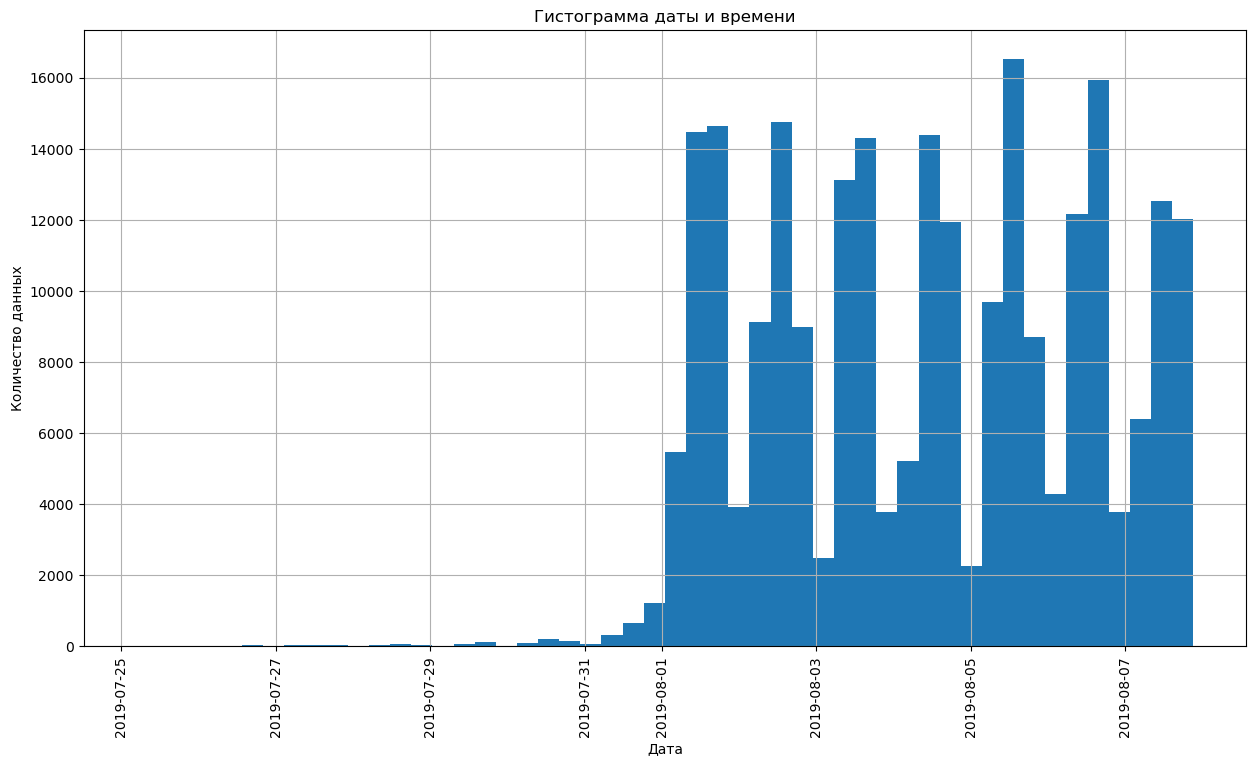

In [18]:
plt.figure(figsize = (15, 8))
data['event_time'].hist(bins = 50)
plt.title("Гистограмма даты и времени")
plt.xlabel('Дата')
plt.ylabel('Количество данных')
plt.xticks(rotation=90)
plt.show()

На гистограмме видно, что до 1 августа количество данных очень мало, далее в зависимости от времени суток количество действий не опускается ниже 2000. Таким образом, целесообразно ограничить данные с 2019-08-01

In [19]:
n_events = len(data)
n_users = data['device_id'].nunique()

Сохраним количество событиый и уникальных пользователей до ограничения данных по дате

In [20]:
data = data.query('event_time >= "2019-08-01"')

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240887 entries, 2828 to 244125
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   event_name        240887 non-null  object        
 1   device_id         240887 non-null  int64         
 2   event_timestampt  240887 non-null  int64         
 3   exp_id            240887 non-null  int64         
 4   event_time        240887 non-null  datetime64[ns]
 5   event_date        240887 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(3), object(1)
memory usage: 12.9+ MB


In [22]:
new_events = len(data)
new_users = data['device_id'].nunique()

In [51]:
print(
f"Абсолютное изменение между старым ({n_events}) и новым ({new_events}) количеством событий составляет {n_events - new_events}\n"
)
print(
f"Относительное изменение между старым ({n_events}) и новым ({new_events}) количеством событий составляет {round((n_events / new_events - 1) * 100, 2)}%\n"
)

print(
f"Абсолютное изменение между старым ({n_users}) и новым ({new_users}) количеством пользователей составляет {n_users - new_users}\n"
)
print(
f"Относительное изменение между старым ({n_users}) и новым ({new_users}) количеством пользователей составляет {round((n_users / new_users - 1) * 100, 2)}%"
)

Абсолютное изменение между старым (243713) и новым (240887) количеством событий составляет 2826

Относительное изменение между старым (243713) и новым (240887) количеством событий составляет 1.17%

Абсолютное изменение между старым (7551) и новым (7534) количеством пользователей составляет 17

Относительное изменение между старым (7551) и новым (7534) количеством пользователей составляет 0.23%


После удаления данных с 25 июля по 1 августа остается 240'887 строк, что на 2826 строк (1,17%) меньше  от данных после очистки от дубликатов.
Также количество пользователей стало меньше на 17 штук, что составляет 0,23%.
Такое количество удаленных данных можно считать допустимым.

In [24]:
data.groupby('exp_id').agg({'device_id': ['count', 'nunique']})

device_id        
           count nunique
exp_id                  
246        79302    2484
247        77022    2513
248        84563    2537

Всего в каждой группе следующее количество записей и пользователей:
- 246: 79302, 2484
- 247: 7702, 2513
- 248: 84563, 2537

В экспериментальной группе больше действий и пользователей 

# Изучение воронки

## Составление воронки

In [25]:
events = data.groupby('event_name').agg({'exp_id': 'count'}).sort_values(by='exp_id', ascending = False)
events

,exp_id
event_name,
MainScreenAppear,117328
OffersScreenAppear,46333
CartScreenAppear,42303
PaymentScreenSuccessful,33918
Tutorial,1005


На последнем месте - туториал, нельзя сказать, что он является частью воронки, поскольку пройти туториал можно в любой момент, а можно и не проходить

Воронка выглядит следующим образом:
- просмотр главного экрана
- экран с предложением
- экран корзины
- экран успешной оплаты

Это логично, к тому же подтверждается тем, что на каждом из этапов пользователей меньше, чем на предыдущем

In [26]:
users = data.groupby('event_name').agg({'device_id': 'nunique'}).sort_values(by='device_id', ascending = False)
users['share'] = round(users['device_id'] / data['device_id'].nunique(), 2)
users.reset_index(inplace=True)
users

,event_name,device_id,share
0,MainScreenAppear,7419,0.98
1,OffersScreenAppear,4593,0.61
2,CartScreenAppear,3734,0.50
3,PaymentScreenSuccessful,3539,0.47
4,Tutorial,840,0.11


2% пользователей не "добираются" до главного экрана, то есть не совершают это событие. Возможно, сайт остановил загрузку,  могут быть и другие причины.

61% пользователей хотя бы раз попадают на экран с предложением

50% пользователей хотя бы раз открывают корзину

47% пользователей совершают оплату

11% пользователей видят/проходят туториал

In [27]:
data = data[data['event_name'] != 'Tutorial']

Для воронки не нужен туториал, что уже упоминалось выше, поэтому далее данные очищаются от этого события

## Построение воронки

In [45]:
#funnel = users[['event_name', 'device_id']].query('event_name != "Tutorial"')
#funnel_dict = dict(values=funnel['device_id'].to_list(),
#            event=funnel['event_name'].to_list())
#fig = px.funnel(funnel_dict,  y='event', x='values', title='Воронка количества пользователей на этап')
#fig.show()

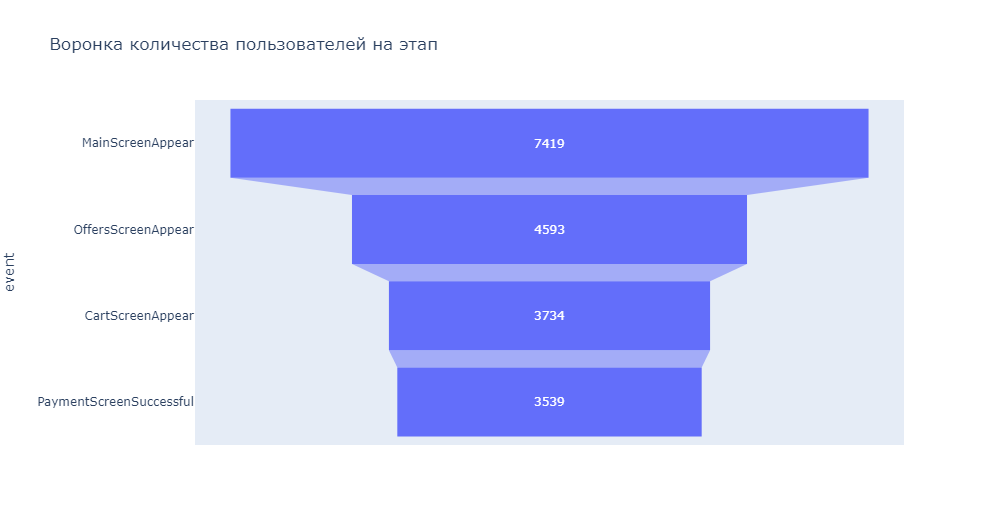

График напоминает воронку, при этом последние две ступени достаточно схожи. Это говорит о том, что практически все пользователи, добавившие товар в корзину, совершают покупку. Посчитаем более точные показатели

In [29]:
funnel['conversion'] = 0

for index in range(0, len(funnel)):
    if index == 0:
        funnel.loc[index, 'conversion'] = 100
    else:
        funnel.loc[index, 'conversion'] = round(funnel.loc[index, 'device_id'] * 100 / funnel.loc[index - 1, 'device_id'], 2)
funnel

,event_name,device_id,conversion
0,MainScreenAppear,7419,100.00
1,OffersScreenAppear,4593,61.91
2,CartScreenAppear,3734,81.30
3,PaymentScreenSuccessful,3539,94.78


Главное падение происходит между этапами главного экрана и просмотром страницы с предложением товара. Это может говорить о том, что:
- товары не привлекают внимание или пользователи не интересуются покупкой
- покупателям понятно, нужен им данный товар или нет, не заходя на страницу предложения

In [30]:
funnel['conversion'] = 0

for index in range(0, len(funnel)):
    if index == 0:
        funnel.loc[index, 'conversion'] = 100
    else:
        funnel.loc[index, 'conversion'] = round(funnel.loc[index, 'device_id'] * 100 / funnel.loc[0, 'device_id'], 2)
funnel

,event_name,device_id,conversion
0,MainScreenAppear,7419,100.00
1,OffersScreenAppear,4593,61.91
2,CartScreenAppear,3734,50.33
3,PaymentScreenSuccessful,3539,47.70


Здесь же видно, что после 1 этапа от всех пользователей порядка 38% не продолжают просмотр страниц, 50% добавляют товар в корзину и около 48% совершают покупку.

## Вывод

Несмотря на резкое падение в воронке на 40% в первом этапе, из всех посетивших на главную странциу, 48% пользователей совершают покупку. Это довольно высокий показатель, воронка проработана хорошо. Возможно улучшение в том случае, если на сайт будет заходить большее количество пользователей, изначально заинтересованных в товаре

# Изучение эксперимента

## Изучение групп 

In [31]:
groups = data.groupby('exp_id').agg({'device_id': ['count', 'nunique']})
groups

device_id        
           count nunique
exp_id                  
246        78985    2483
247        76684    2512
248        84213    2535

В каждой экспериментальной группе около 2500 пользователей

## А/А-тест

In [32]:
user_group=data.groupby('device_id')['exp_id'].nunique()
check=data.merge(user_group, on=["device_id", "device_id"])
check=check[check['exp_id_y'] >= 2]
check['device_id'].nunique()

0

Ни один из пользователей не попадает в 2 или более группы

In [33]:
data_246 = data[data['exp_id'] == 246]

In [34]:
data_247 = data[data['exp_id'] == 247]

Создаются группы для 246 и 247 группы для проверки дат и зафиксированных событий в группе

In [35]:
print('Минимальная и максимальная дата в группе 246:', data_246['event_time'].min(), data_246['event_time'].max())
print('Минимальная и максимальная дата в группе 247:', data_247['event_time'].min(), data_247['event_time'].max())

Минимальная и максимальная дата в группе 246: 2019-08-01 00:08:00 2019-08-07 21:15:17
Минимальная и максимальная дата в группе 247: 2019-08-01 00:08:59 2019-08-07 21:12:25


In [36]:
print('Вариантов событий в группе 246:', data_246['event_name'].nunique())
print('Вариантов событий в группе 247:', data_247['event_name'].nunique())

Вариантов событий в группе 246: 4
Вариантов событий в группе 247: 4


Разница во времени между началом и концом эксперимента в группах исчисляется минутами. При этом в каждой группе по 4 варианта событий (туториал не рассматривается)

Проводится z-тест (проверка гипотезы о равенстве долей). Если некоторая доля генеральной совокупности обладает признаком, а другая её часть — нет, об этой доле можно судить по выборке из генеральной совокупности. 

**H0:** между групп 246 и 247 нет различий в долях

**H1:** между долями есть значимая разница

**альфа-значение:** 0.05

In [37]:
def test_z(group_1, group_2, event, alpha):
      
    def successes_trials(group1, group2, event):
            successes = (
                np
                .array([data.query(f'exp_id.isin({group1}) & event_name == "{event}"')['device_id'].nunique(),
                          data.query(f'exp_id == {group_2} & event_name == "{event}"')['device_id'].nunique()])
            )
            trials = (
                np
                .array([data.query(f'exp_id.isin({group1})')['device_id'].nunique(),\
                           data.query(f'exp_id == {group_2}')['device_id'].nunique()])
            )
            return successes, trials
        
    successes, trials = successes_trials(group_1, group_2, event) 
# пропорция успехов в первой группе:
    p1 = successes[0]/trials[0]
# пропорция успехов во второй группе: 
    p2 = successes[1]/trials[1]
# пропорция успехов в комбинированном датасете: 
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])
 
    difference = p1 - p2 

    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))
 
    distr = st.norm(0, 1) 
 
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    print(f'Группы {group_1} и {group_2}. Событие {event}')
 
    print('p-значение: ', round(p_value, 4))
    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
        )

Проведем тест по каждой группе с упомянутыми выше гипотезами

In [38]:
alpha = 0.05 # критический уровень статистической значимости
group_1 = [246]
group_2 = 247

test_z(group_1, group_2, 'MainScreenAppear', alpha)

Группы [246] и 247. Событие MainScreenAppear
p-значение:  0.7527
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Самая большая группа - просмотр главного экрана. Здесь p-значение составило 0,7571, что много выше 0,05. Увеличение значения до 0,1 не дало бы другого ответа о верности нулевой гипотезы

In [39]:
test_z(group_1, group_2, 'OffersScreenAppear', alpha)

Группы [246] и 247. Событие OffersScreenAppear
p-значение:  0.2479
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


p-значение составило 0,2481, выше 0,05, нулевая гипотеза не отвергнута

In [40]:
test_z(group_1, group_2, 'CartScreenAppear', alpha)

Группы [246] и 247. Событие CartScreenAppear
p-значение:  0.2287
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


p-значение составило 0,2288, выше 0,05, нулевая гипотеза не отвергнута

In [41]:
test_z(group_1, group_2, 'PaymentScreenSuccessful', alpha)

Группы [246] и 247. Событие PaymentScreenSuccessful
p-значение:  0.1145
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


p-значение составило 0,1146, выше 0,05, даже при значении альфа = 0,1, нулевая гипотеза не будет отвергнута

## А/В-тест

Так же роводится z-тест (проверка гипотезы о равенстве долей).

**H0:** между групп 246, либо 247 и 248 нет различий в долях

**H1:** между долями есть значимая разница

**альфа-значение:** 0.05

In [42]:
group_2 = 248

test_z(group_1, group_2, 'MainScreenAppear', alpha)
test_z(group_1, group_2, 'OffersScreenAppear', alpha)
test_z(group_1, group_2, 'CartScreenAppear', alpha)
test_z(group_1, group_2, 'PaymentScreenSuccessful', alpha)

Группы [246] и 248. Событие MainScreenAppear
p-значение:  0.3387
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Группы [246] и 248. Событие OffersScreenAppear
p-значение:  0.2144
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Группы [246] и 248. Событие CartScreenAppear
p-значение:  0.0807
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Группы [246] и 248. Событие PaymentScreenSuccessful
p-значение:  0.2169
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


В этом случае каждая из гипотез отвергается. При этом, при повышении альфа до 0,1 в случае с событием добавления товара в корзину, была бы принята альтернативная гипотеза. В этом случае новый шрифт привел бы к тому, что больше пользователей заходят в корзину, но оплачивают такое же количество, как и прежде

In [43]:
group_1 = [247]

test_z(group_1, group_2, 'MainScreenAppear', alpha)
test_z(group_1, group_2, 'OffersScreenAppear', alpha)
test_z(group_1, group_2, 'CartScreenAppear', alpha)
test_z(group_1, group_2, 'PaymentScreenSuccessful', alpha)

Группы [247] и 248. Событие MainScreenAppear
p-значение:  0.5195
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Группы [247] и 248. Событие OffersScreenAppear
p-значение:  0.9334
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Группы [247] и 248. Событие CartScreenAppear
p-значение:  0.5878
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Группы [247] и 248. Событие PaymentScreenSuccessful
p-значение:  0.7276
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Сравнение групп 247 и экспериментальной приводит к выовду о том, что всё же шрифт не повлиял на поведение пользователей. Здесь p-значение в каждом из вариантов много превышает и значение 0,05, и 0,1.

**H0:** между групп объединенными контрольными группами (246,247) и 248 нет различий в долях

**H1:** между долями есть значимая разница

**альфа-значение:** 0.05

In [44]:
group_1 = [246, 247]

test_z(group_1, group_2, 'MainScreenAppear', alpha)
test_z(group_1, group_2, 'OffersScreenAppear', alpha)
test_z(group_1, group_2, 'CartScreenAppear', alpha)
test_z(group_1, group_2, 'PaymentScreenSuccessful', alpha)

Группы [246, 247] и 248. Событие MainScreenAppear
p-значение:  0.3487
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Группы [246, 247] и 248. Событие OffersScreenAppear
p-значение:  0.4458
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Группы [246, 247] и 248. Событие CartScreenAppear
p-значение:  0.1868
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Группы [246, 247] и 248. Событие PaymentScreenSuccessful
p-значение:  0.6108
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Объединение групп ещё раз подтвердило то, что нулевая гипотеза не отвергается. Все значение выше как 0,05, так и 0,1

## Вывод

А/А-эксперимент показал, что контрольные группы не различаются значительно. Также можно сделать вывод о том, что изменение шрифта не повлияло на поведение пользователей.

Всего было проведено 16 статистических тестов (4 группы * 4 комбинации), 4 из них для проверки А/А-теста, 12 - для проверки А/В теста. Вероятность ложнопозитивного результата для 12 групп составит 0,46, а для 16 - 0,56. Уменьшение значения альфа до 0,01 (выводы теста не изменятся) снизило бы эти значения до 0,11 и 0,15.

# Итого

- в среднем пользователи совершают 20 событий на сайте
- около 48% пользователей доходят до страницы успешной оплаты
- при этом, 40% пользователей не переходят с главной страницы до страницы продукта
- от страницы продукта до корзины теряется ещё 20%
- практически все пользователи (95%), положившие товар в корзину, совершают покупку
- изменение шрифта никак не повлияло на пользователей, при этом нужно отметить то, что данные собраны качественно